# Experiment 2: Adversarial Detection

In this experiment, we evaluate the ensembles approach on the task of adversarial detection. We compare it with the Mahanalobis detector.

### Imports

In [1]:
import numpy as np

# sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# torch
import torch
from torchvision import datasets, transforms

# own modules
import densenet
import resnet
import utils.dnn_utils as dnn_utils
import utils.experiment_utils as exp_utils
import utils.ensemble_utils as ens_utils
import utils.metrics as metrics
import utils.plots as myplots

## Setting

We run the experiments below using the same setting of the Mahanalobis paper. We use their pretrained Neural Nets, one Densenet and one Resnet, and use the same In-Distribution (IND) datasets and preprocessings, and adversarial attacks (with the same parameters). We test the setting where approaches don't have access to data of the attack applied for hyperparameter tuning. Finally, below we evaluate only our approach; the results Mahanalobis can be found in their paper, and reproduced running the official code.

A quick summary of our approach is shown in the image below. Basically, we extract the features of the penultimate layer, and apply a small ensemble on top. Then, we use the ensemble members to estimate the uncertainty of some new input, using the predictions entropy.

![title](figs/approach.png)

## Experiment 1: CIFAR 10 on Densenet (FGSM)

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, adversarial attack type and params, etc.

In [2]:
# load the model
model_type = 'densenet'
pre_trained_net = 'models/densenet_cifar10.pth'
model = torch.load(pre_trained_net)
# fix model (due to previous torch version)
dnn_utils.fix_model(model)
# put model in eval mode
model.eval()

# some extra params
batch_size = 20
n_classes = 10
layer_sizes_mean = [24, 108, 150, 342, n_classes]
# normalization transform for that model
min_pixel = -1.98888885975
max_pixel = 2.12560367584
norm_trans_std = (63.0/255, 62.1/255.0, 66.7/255.0) 
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0)),])

# adv attack settings
adv_type = 'FGSM'

if adv_type == 'FGSM':
    adv_noise = 0.05
elif adv_type == 'BIM':
    adv_noise = 0.01
else:
    adv_noise = 0.01

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseNet3' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dum

### Load datasets

Then, we load the IND and OOD datasets

In [3]:
# load data
# CIFAR10
trainset = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

if model_type == 'densenet':
    if adv_type == 'FGSM':
        random_noise_size = 0.21 / 4
    elif adv_type == 'BIM':
        random_noise_size = 0.21 / 4
    elif adv_type == 'DeepFool':
        random_noise_size = 0.13 * 2 / 10
        adv_noise = 0.6
    elif adv_type == 'CWL2':
        random_noise_size = 0.03 / 2
elif model_type == 'resnet':
    if adv_type == 'FGSM':
        random_noise_size = 0.25 / 4
    elif adv_type == 'BIM':
        random_noise_size = 0.13 / 2
    elif adv_type == 'DeepFool':
        random_noise_size = 0.25 / 4
        adv_noise = 0.18
    elif adv_type == 'CWL2':
        random_noise_size = 0.05 / 2

Files already downloaded and verified
Files already downloaded and verified


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later. Here, we obtain intermediate features for the clean as well as for the perturbed data. In some cases, we extract features only for a random sample of the perturbed data, since some adversarial attacks are slow (typically around 1000 samples).

In [4]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# collect adversarially perturbed activations

# IND adv features
C, Cres = exp_utils.collectActivAdv(ind_test_loader, model, n_classes, layer_sizes_mean, adv_type, 
                                    random_noise_size, min_pixel, max_pixel, norm_trans_std, 
                                    adv_noise, 1000)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out)

 12%|██████████                                                                       | 62/500 [01:05<07:47,  1.07s/it]


 13%|██████████▊                                                                      | 67/500 [01:11<07:37,  1.06s/it]

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and ADV).

In [5]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


 10%|████████▎                                                                          | 1/10 [00:02<00:25,  2.82s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


 20%|████████████████▌                                                                  | 2/10 [00:05<00:22,  2.75s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimi

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

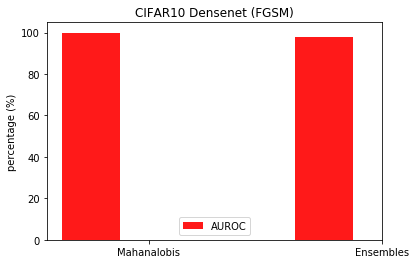

In [6]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
AUROC_ALL = (99.9, 100 * auroc)

# plot bar chart
myplots.make_barplot([AUROC_ALL], 
                     'CIFAR10 Densenet (FGSM)', ['Mahanalobis', 'Ensembles'], 
                     ['AUROC'])

## Experiment 2: CIFAR 100 on Densenet (BIM)

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, adversarial attack type and params, etc.

In [7]:
# load the model
model_type = 'densenet'
pre_trained_net = 'models/densenet_cifar100.pth'
model = torch.load(pre_trained_net)
# fix model (due to previous torch version)
dnn_utils.fix_model(model)
# put model in eval mode
model.eval()

# some extra params
batch_size = 10 # we set low batch size to some cases, in case of gpu memory issues
n_classes = 100
layer_sizes_mean = [24, 108, 150, 342, n_classes]
# normalization transform for that model
min_pixel = -1.98888885975
max_pixel = 2.12560367584
norm_trans_std = (63.0/255, 62.1/255.0, 66.7/255.0) 
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0)),])

# adv attack settings
adv_type = 'BIM'

if adv_type == 'FGSM':
    adv_noise = 0.05
elif adv_type == 'BIM':
    adv_noise = 0.01
else:
    adv_noise = 0.01

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseNet3' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dum

### Load datasets

Then, we load the IND and OOD datasets

In [8]:
# load data
# CIFAR100
trainset = datasets.CIFAR100(root='data', train=True,
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.CIFAR100(root='data', train=False,
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

if model_type == 'densenet':
    if adv_type == 'FGSM':
        random_noise_size = 0.21 / 8
    elif adv_type == 'BIM':
        random_noise_size = 0.21 / 8
    elif adv_type == 'DeepFool':
        random_noise_size = 0.13 * 2 / 8
        adv_noise = 0.1
    elif adv_type == 'CWL2':
        random_noise_size = 0.06 / 5
elif model_type == 'resnet':
    if adv_type == 'FGSM':
        random_noise_size = 0.25 / 8
    elif adv_type == 'BIM':
        random_noise_size = 0.13 / 4
    elif adv_type == 'DeepFool':
        random_noise_size = 0.13 / 4
        adv_noise = 0.03
    elif adv_type == 'CWL2':
        random_noise_size = 0.05 / 2

Files already downloaded and verified
Files already downloaded and verified


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later. Here, we obtain intermediate features for the clean as well as for the perturbed data. In some cases, we extract features only for a random sample of the perturbed data, since some adversarial attacks are slow (typically around 1000 samples).

In [2]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# collect adversarially perturbed activations

# IND adv features
C, Cres = exp_utils.collectActivAdv(ind_test_loader, model, n_classes, layer_sizes_mean, adv_type, 
                                    random_noise_size, min_pixel, max_pixel, norm_trans_std, 
                                    adv_noise, 1000)

NameError: name 'ind_train_loader' is not defined

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and ADV).

In [10]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)




 10%|████████▎                                                                          | 1/10 [00:05<00:52,  5.88s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)




 20%|████████████████▌                                                                  | 2/10 [00:11<00:46,  5.87s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic 

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

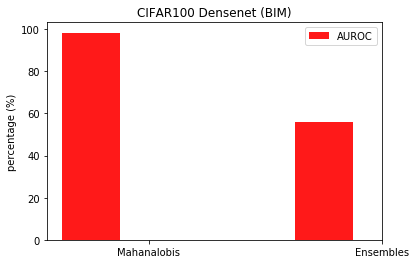

In [11]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
AUROC_ALL = (98.3, 100 * auroc)

# plot bar chart
myplots.make_barplot([AUROC_ALL], 
                     'CIFAR100 Densenet (BIM)', ['Mahanalobis', 'Ensembles'], 
                     ['AUROC'])

## Experiment 3: CIFAR 100 on Resnet (Carlini Wagner)

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, adversarial attack type and params, etc.

In [2]:
# load the model
model_type = 'resnet'
device = 'cuda'
pre_trained_net = '../models/resnet_cifar100.pth'
n_classes = 100
model = resnet.ResNet34(num_c = n_classes).to(device)
# load the model
model.load_state_dict(torch.load(pre_trained_net, map_location = device))
# set in eval mode
model.eval()

# some extra params
batch_size = 10
layer_sizes_mean = [64, 64, 128, 256, 512, n_classes]
# normalization transform for that model
min_pixel = -2.42906570435
max_pixel = 2.75373125076
norm_trans_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
# adv attack settings
adv_type = 'CWL2'

if adv_type == 'FGSM':
    adv_noise = 0.05
elif adv_type == 'BIM':
    adv_noise = 0.01
else:
    adv_noise = 0.01

### Load datasets

Then, we load the IND and OOD datasets

In [3]:
# load data
# CIFAR100
trainset = datasets.CIFAR100(root='data', train=True,
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.CIFAR100(root='data', train=False,
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

if model_type == 'densenet':
    if adv_type == 'FGSM':
        random_noise_size = 0.21 / 8
    elif adv_type == 'BIM':
        random_noise_size = 0.21 / 8
    elif adv_type == 'DeepFool':
        random_noise_size = 0.13 * 2 / 8
        adv_noise = 0.1
    elif adv_type == 'CWL2':
        random_noise_size = 0.06 / 5
elif model_type == 'resnet':
    if adv_type == 'FGSM':
        random_noise_size = 0.25 / 8
    elif adv_type == 'BIM':
        random_noise_size = 0.13 / 4
    elif adv_type == 'DeepFool':
        random_noise_size = 0.13 / 4
        adv_noise = 0.03
    elif adv_type == 'CWL2':
        random_noise_size = 0.05 / 2

Files already downloaded and verified
Files already downloaded and verified


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later. Here, we obtain intermediate features for the clean as well as for the perturbed data. In some cases, we extract features only for a random sample of the perturbed data, since some adversarial attacks are slow (typically around 1000 samples).

In [ ]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 500)

# collect adversarially perturbed activations

# IND adv features
C, Cres = exp_utils.collectActivAdv(ind_test_loader, model, n_classes, layer_sizes_mean, adv_type, 
                                    random_noise_size, min_pixel, max_pixel, norm_trans_std, 
                                    adv_noise, 500)

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and ADV).

In [10]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 10%|████████▎                                                                          | 1/10 [00:04<00:42,  4.69s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 20%|████████████████▌                                                                  | 2/10 [00:09<00:37,  4.67s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

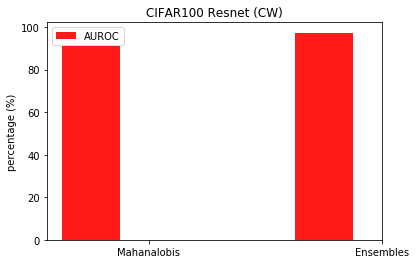

In [11]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
AUROC_ALL = (91, 100 * auroc)

# plot bar chart
myplots.make_barplot([AUROC_ALL], 
                     'CIFAR100 Resnet (CW)', ['Mahanalobis', 'Ensembles'], 
                     ['AUROC'])

## Experiment 4: SVHN on Resnet (Deep Fool)

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, adversarial attack type and params, etc.

In [12]:
# load the model
model_type = 'resnet'
device = 'cuda'
pre_trained_net = '../models/resnet_svhn.pth'
n_classes = 10
model = resnet.ResNet34(num_c = n_classes).to(device)
# load the model
model.load_state_dict(torch.load(pre_trained_net, map_location = device))
# set in eval mode
model.eval()

# some extra params
batch_size = 10
layer_sizes_mean = [64, 64, 128, 256, 512, n_classes]
# normalization transform for that model
min_pixel = -2.42906570435
max_pixel = 2.75373125076
norm_trans_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
# adv attack settings
adv_type = 'DeepFool'

if adv_type == 'FGSM':
    adv_noise = 0.05
elif adv_type == 'BIM':
    adv_noise = 0.01
else:
    adv_noise = 0.01

### Load datasets

Then, we load the IND and OOD datasets

In [13]:
# load data
# SVHN
trainset = datasets.SVHN(root='data', split='train',
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.SVHN(root='data', split='test',
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

if model_type == 'densenet':
    if adv_type == 'FGSM':
        random_noise_size = 0.21 / 4
    elif adv_type == 'BIM':
        random_noise_size = 0.21 / 4
    elif adv_type == 'DeepFool':
        random_noise_size = 0.16 * 2 / 5
        adv_noise = 0.5
    elif adv_type == 'CWL2':
        random_noise_size = 0.07 / 2
elif model_type == 'resnet':
    if adv_type == 'FGSM':
        random_noise_size = 0.25 / 4
    elif adv_type == 'BIM':
        random_noise_size = 0.13 / 2
    elif adv_type == 'DeepFool':
        random_noise_size = 0.126
        adv_noise = 0.1
    elif adv_type == 'CWL2':
        random_noise_size = 0.05 / 1

Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\test_32x32.mat


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later. Here, we obtain intermediate features for the clean as well as for the perturbed data. In some cases, we extract features only for a random sample of the perturbed data, since some adversarial attacks are slow (typically around 1000 samples).

In [ ]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 500)

# collect adversarially perturbed activations

# IND adv features
C, Cres = exp_utils.collectActivAdv(ind_test_loader, model, n_classes, layer_sizes_mean, adv_type, 
                                    random_noise_size, min_pixel, max_pixel, norm_trans_std, 
                                    adv_noise, 500)

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and ADV).

In [15]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 10%|████████▎                                                                          | 1/10 [00:03<00:30,  3.41s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)

 20%|████████████████▌                                                                  | 2/10 [00:06<00:27,  3.42s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

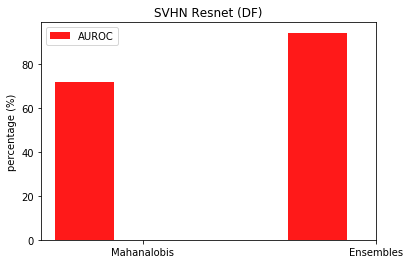

In [16]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
AUROC_ALL = (72.2, 100 * auroc)

# plot bar chart
myplots.make_barplot([AUROC_ALL], 
                     'SVHN Resnet (DF)', ['Mahanalobis', 'Ensembles'], 
                     ['AUROC'])